# 06.6 - Transformative pipeline with large files

<div class="alert alert-danger">
    <b> Create a specific virtual environment for this notebook! <b>
</div>
        
Make sure you are running this notebook in the virtual environment from the dask.yml file.

---

In this exercise, we are going to download some large files into a local directory.

We are going to use taxi-cab datasets from NYC. You can get the data from here:
https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

---

In [1]:
from dask.distributed import Client
# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client() #IF YOU ARE NOT SURE OF THE ARGUMENTS, DON'T USE ANY!
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55458,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.75 GiB
Comm: tcp://127.0.0.1:55481,Total threads: 3
Dashboard: http://127.0.0.1:55482/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:55461,


In [12]:
import dask.dataframe as dd
import dask
dask.config.set({"visualization.engine": "cytoscape"})

In [13]:
df = dd.read_parquet("../Large_Files/yellow_tripdata_2015-01.parquet")

In [14]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=1,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
dmean = df.passenger_count.mean()

In [16]:
dmean.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [7]:
%%time
dmean.compute()

CPU times: user 469 ms, sys: 29.9 ms, total: 499 ms
Wall time: 2.63 s


1.6814908260154964

---
We actually have more than one file. We have a file for each month. It is possible to open all files with a rule set.

In [8]:
df = dd.read_parquet("../Large_Files/yellow_tripdata_2015-*.parquet")

In [9]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=2,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],int64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


There are now more partitions than before. We are analysing 3 months of data. The DAG becomes too big!

In [11]:
dmean = df.passenger_count.mean()
dmean.visualize(engine='cytoscape')

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [11]:
%%time
dmean.compute()

CPU times: user 1.12 s, sys: 60.6 ms, total: 1.18 s
Wall time: 6.75 s


1.6739811371478843

---

In [12]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [38]:
arram = df.tip_amount.to_dask_array()

In [39]:
type(arram)

dask.array.core.Array

In [43]:
## Additional analysis tools
import dask.array as da

In [44]:
h, bins = da.histogram(arram, bins=20, range=[0, 20])

In [45]:
h.visualize()

<div class="alert alert-danger">
    <b> This is a heavy calculation! You better store it in a variable. It will have only a couple of bins, so it is safe to store it in memory. <b>
</div>

In [48]:
heights = h.compute()

In [49]:
bins

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [50]:
import matplotlib.pyplot as plt

In [51]:
bins

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

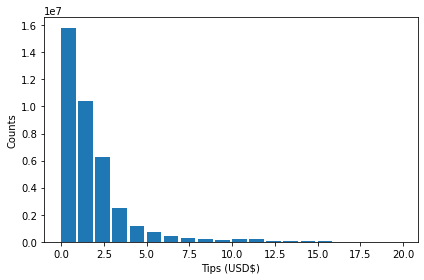

In [53]:
# This is a histogram. It requires a small handling trick to produce a workable plot. See if you notice it.
left_edges = bins[:-1]
width = 0.85*(left_edges[1] - left_edges[0])

plt.bar(left_edges, heights, align='edge', width=width)
plt.xlabel("Tips (USD$)")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

---
How do the numerical variables relate to one another? Let's see if there's any correlation between numerical columns.

In [81]:
da = df[['fare_amount','tip_amount','passenger_count','trip_distance']]

In [82]:
da

,fare_amount,tip_amount,passenger_count,trip_distance
npartitions=93,,,,
,float64,float64,int64,float64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [83]:
da.corr()

,fare_amount,tip_amount,passenger_count,trip_distance
npartitions=1,,,,
fare_amount,float64,float64,float64,float64
trip_distance,...,...,...,...


In [84]:
dcorr = da.corr().compute()

In [85]:
dcorr

,fare_amount,tip_amount,passenger_count,trip_distance
fare_amount,1.000000,2.348966e-04,0.000712,5.072671e-05
tip_amount,0.000235,1.000000e+00,-0.000106,-6.868879e-08
passenger_count,0.000712,-1.056830e-04,1.000000,-3.558416e-04
trip_distance,0.000051,-6.868879e-08,-0.000356,1.000000e+00


In [91]:
import seaborn as sns
import numpy as np

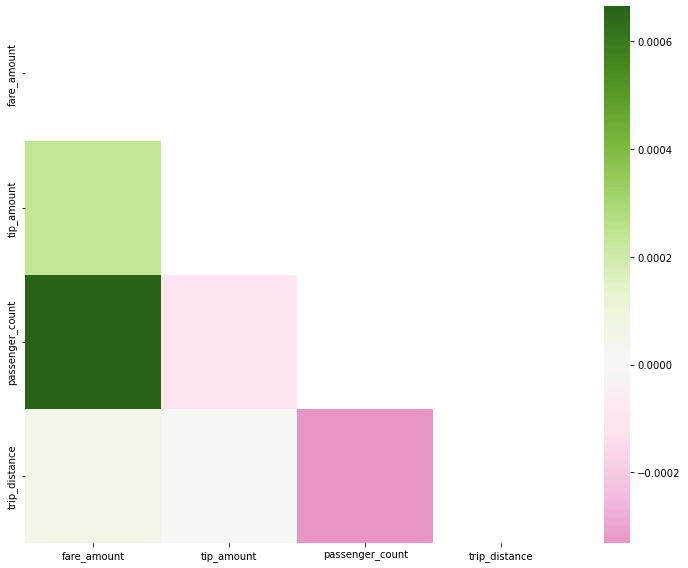

In [92]:
fig, ax = plt.subplots(figsize=(10,8))

mask = np.zeros_like(dcorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dcorr, mask=mask, cmap='PiYG', center=0, robust=True)

# Auto-compose the image
plt.tight_layout()
plt.show()

Wow, the correlations are minimal... this is a tough dataset!